# Atlas Vector Search - Vector Quantization - Automatic Quantization with Voyage AI

This notebook is a companion to the [Automatic Quantization with Voyage AI](https://www.mongodb.com/docs/atlas/atlas-vector-search/tutorials/auto-quantize-with-voyage-ai/) tutorial. Refer to the page for set-up instructions and detailed explanations.

This tutorial details techniques needed to design, deploy, and manage advanced AI workloads at scale, ensuring optimal performance and cost efficiency.

<a target="_blank" href="https://colab.research.google.com/drive/19v0-KnkMAf7gFvvW-prQUnTlJVrri96V#scrollTo=QBVrxbA0aQEg">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
pip install --quiet datasets==3.6.0 gcsfs==2025.3.0 fsspec==2025.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.9 MB/s eta 0:00:00


In [2]:
pip install --quiet pymongo voyageai pandas==2.2.2 matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 16.7 MB/s eta 0:00:00


In [7]:
import getpass
import os
import voyageai

# Function to securely get and set environment variables
def set_env_securely(var_name, prompt):
    value = getpass.getpass(prompt)
    os.environ[var_name] = value

# Environment Variables
set_env_securely("VOYAGE_API_KEY", "Enter your Voyage API Key: ")
set_env_securely("MONGO_URI", "Enter your MongoDB URI: ")
MONGO_URI = os.environ.get("MONGO_URI")
if not MONGO_URI:
    raise ValueError("MONGO_URI not set in environment variables.")

# Voyage Client
voyage_client = voyageai.Client()

Enter your Voyage API Key: ··········
Enter your MongoDB URI: ··········


In [8]:
import pandas as pd
from datasets import load_dataset
from bson.binary import Binary, BinaryVectorDtype
import pymongo

# Connect to Cluster
def get_mongo_client(uri):
    """Connect to MongoDB and confirm the connection."""
    client = pymongo.MongoClient(uri)
    if client.admin.command("ping").get("ok") == 1.0:
        print("Connected to MongoDB successfully.")
        return client
    print("Failed to connect to MongoDB.")
    return None

# Generate BSON Vector
def generate_bson_vector(array, data_type):
    """Convert an array to BSON vector format."""
    array = [float(val) for val in eval(array)]
    return Binary.from_vector(array, BinaryVectorDtype(data_type))

# Load Datasets
def load_and_prepare_data(dataset_name, amount):
    """Load and prepare streaming datasets for DataFrame."""
    data = load_dataset(dataset_name, streaming=True, split="train").take(amount)
    return pd.DataFrame(data)

# Insert datasets into MongoDB Collection
def insert_dataframe_into_collection(df, collection):
    """Insert Dataset records into MongoDB collection."""
    collection.insert_many(df.to_dict("records"))
    print(f"Inserted {len(df)} records into '{collection.name}' collection.")

In [10]:
import pandas as pd
from bson.binary import Binary, BinaryVectorDtype
from pymongo.errors import CollectionInvalid

wikipedia_data_df = load_and_prepare_data("MongoDB/wikipedia-22-12-en-voyage-embed", amount=2500)
wikipedia_annotation_data_df = load_and_prepare_data("MongoDB/wikipedia-22-12-en-annotation", amount=2500)
wikipedia_annotation_data_df.drop(columns=["_id"], inplace=True)

# Convert embeddings to BSON format
wikipedia_data_df["embedding"] = wikipedia_data_df["embedding"].apply(
    lambda x: generate_bson_vector(x, BinaryVectorDtype.FLOAT32)
)

# MongoDB Setup
mongo_client = get_mongo_client(MONGO_URI)
DB_NAME = "testing_datasets"
db = mongo_client[DB_NAME]

collections = {
    "wikipedia-22-12-en": wikipedia_data_df,
    "wikipedia-22-12-en-annotation": wikipedia_annotation_data_df,
}

# Create Collections and Insert Data
for collection_name, df in collections.items():
    if collection_name not in db.list_collection_names():
        try:
            db.create_collection(collection_name)
            print(f"Collection '{collection_name}' created successfully.")
        except CollectionInvalid:
            print(f"Error creating collection '{collection_name}'.")
    else:
        print(f"Collection '{collection_name}' already exists.")

    # Clear collection and insert fresh data
    collection = db[collection_name]
    collection.delete_many({})
    insert_dataframe_into_collection(df, collection)

Connected to MongoDB successfully.
Collection 'wikipedia-22-12-en' created successfully.
Inserted 2500 records into 'wikipedia-22-12-en' collection.
Collection 'wikipedia-22-12-en-annotation' created successfully.
Inserted 2500 records into 'wikipedia-22-12-en-annotation' collection.


In [11]:
import time
from pymongo.operations import SearchIndexModel

def setup_vector_search_index(collection, index_definition, index_name="vector_index"):
    new_vector_search_index_model = SearchIndexModel(
        definition=index_definition, name=index_name, type="vectorSearch"
    )

    # Create the new index
    try:
        result = collection.create_search_index(model=new_vector_search_index_model)
        print(f"Creating index '{index_name}'...")

        # Wait for initial sync to complete
        print("Polling to check if the index is ready. This may take around a minute.")
        predicate=None
        if predicate is None:
            predicate = lambda index: index.get("queryable") is True
            while True:
                indices = list(collection.list_search_indexes(result))
                if len(indices) and predicate(indices[0]):
                    break
                time.sleep(5)
        print(f"Index '{index_name}' is ready for querying.")
        return result

    except Exception as e:
        print(f"Error creating new vector search index '{index_name}': {e!s}")
        return None

In [12]:
vector_index_definition_scalar_quantized = {
  "fields": [
      {
          "type": "vector",
          "path": "embedding",
          "quantization": "scalar",  # Added quantization for scalar vector quantization
          "numDimensions": 1024,
          "similarity": "cosine",
      }
  ]
}

vector_index_definition_binary_quantized = {
  "fields": [
      {
          "type": "vector",
          "path": "embedding",
          "quantization": "binary",  # Changed quantization to binary for binary vector quantization
          "numDimensions": 1024,
          "similarity": "cosine",
      }
  ]
}

vector_index_definition_float32_ann = {
  "fields": [
      {
          "type": "vector",
          "path": "embedding",
          "numDimensions": 1024,
          "similarity": "cosine",
      }
  ]
}

In [13]:
import pymongo
vector_search_scalar_quantized_index_name = "vector_index_scalar_quantized"
vector_search_binary_quantized_index_name = "vector_index_binary_quantized"
vector_search_float32_ann_index_name = "vector_index_float32_ann"
db = mongo_client[DB_NAME]
wiki_data_collection = db["wikipedia-22-12-en"]
wiki_annotation_data_collection = db["wikipedia-22-12-en-annotation"]

In [14]:
from pymongo.operations import SearchIndexModel

setup_vector_search_index(
    wiki_data_collection,
    vector_index_definition_scalar_quantized,
    vector_search_scalar_quantized_index_name,
)
setup_vector_search_index(
    wiki_data_collection,
    vector_index_definition_binary_quantized,
    vector_search_binary_quantized_index_name,
)
setup_vector_search_index(
    wiki_data_collection,
    vector_index_definition_float32_ann,
    vector_search_float32_ann_index_name,
)

Creating index 'vector_index_scalar_quantized'...
Polling to check if the index is ready. This may take around a minute.
Index 'vector_index_scalar_quantized' is ready for querying.
Creating index 'vector_index_binary_quantized'...
Polling to check if the index is ready. This may take around a minute.
Index 'vector_index_binary_quantized' is ready for querying.
Creating index 'vector_index_float32_ann'...
Polling to check if the index is ready. This may take around a minute.
Index 'vector_index_float32_ann' is ready for querying.


'vector_index_float32_ann'

In [15]:
def get_embedding(text, task_prefix="document"):
    """Fetch embedding for a given text using Voyage AI."""
    if not text.strip():
        print("Empty text provided for embedding.")
        return []
    result = voyage_client.embed([text], model="voyage-3-large", input_type=task_prefix)
    return result.embeddings[0]

def custom_vector_search(
    user_query,
    collection,
    embedding_path,
    vector_search_index_name="vector_index",
    top_k=5,
    num_candidates=25,
    use_full_precision=False,
):
    """Perform vector search on a MongoDB collection using specified index."""
    # Generate embedding for the user query
    query_embedding = get_embedding(user_query, task_prefix="query")

    if query_embedding is None or not query_embedding:
        return {
            "error": "Invalid query or embedding generation failed.",
            "execution_time_ms": None,
            "results": [],
        }

    # Define the vector search stage
    vector_search_stage = {
        "$vectorSearch": {
            "index": vector_search_index_name,
            "queryVector": query_embedding,
            "path": embedding_path,
            "limit": top_k,
        }
    }

    # Configure search precision approach
    if not use_full_precision:
        # For approximate nearest neighbor (ANN) search
        vector_search_stage["$vectorSearch"]["numCandidates"] = num_candidates
    else:
        # For exact nearest neighbor (ENN) search
        vector_search_stage["$vectorSearch"]["exact"] = True

    # Project stage to fetch desired fields and vector search score
    project_stage = {
        "$project": {
            "_id": 0,
            "title": 1,
            "text": 1,
            "wiki_id": 1,
            "url": 1,
            "score": {"$meta": "vectorSearchScore"},
        }
    }

    # Define the aggregate pipeline
    pipeline = [vector_search_stage, project_stage]

    try:
        # Execute the explain command to measure latency
        explain_result = collection.database.command(
            "explain",
            {"aggregate": collection.name, "pipeline": pipeline, "cursor": {}},
            verbosity="executionStats",
        )

        # Extract the execution time
        vector_search_explain = explain_result["stages"][0]["$vectorSearch"]
        execution_time_ms = vector_search_explain["explain"]["query"]["stats"]["context"]["millisElapsed"]

        # Execute the actual aggregate query
        results = list(collection.aggregate(pipeline))

        return {
            "results": results,
            "execution_time_ms": execution_time_ms,
        }
    except Exception as e:
        print(f"Error during vector search: {e}")
        return {
            "error": str(e),
            "execution_time_ms": None,
            "results": [],
        }

In [16]:
vector_search_indicies = [
    vector_search_float32_ann_index_name,
    vector_search_scalar_quantized_index_name,
    vector_search_binary_quantized_index_name,
]

# Random query
user_query = "How do I increase my productivity for maximum output"
test_top_k = 5
test_num_candidates = 25

# Result is a list of dictionaries with the following headings: precision, top_k, latency_ms, results
results = []

for vector_search_index in vector_search_indicies:
# Conduct a vector search operation using scalar quantized
  vector_search_results = custom_vector_search(
      user_query,
      wiki_data_collection,
      embedding_path="embedding",
      vector_search_index_name=vector_search_index,
      top_k=test_top_k,
      num_candidates=test_num_candidates,
      use_full_precision=False,
  )
  # Include the precision in the results
  precision = vector_search_index.split("vector_index")[1]
  precision = precision.replace("quantized", "").capitalize()

  results.append(
      {
          "precision": precision,
          "top_k": test_top_k,
          "num_candidates": test_num_candidates,
          "latency_ms": vector_search_results["execution_time_ms"],
          "results": vector_search_results["results"][
              0
          ],  # Just taking the first result
      }
  )

# Conduct a vector search operation using full precision
precision = "Float32_ENN"
vector_search_results = custom_vector_search(
    user_query,
    wiki_data_collection,
    embedding_path="embedding",
    vector_search_index_name="vector_index_scalar_quantized",
    top_k=test_top_k,
    num_candidates=test_num_candidates,
    use_full_precision=True,
)

results.append(
    {
        "precision": precision,
        "top_k": test_top_k,
        "num_candidates": test_num_candidates,
        "latency_ms": vector_search_results["execution_time_ms"],
        "results": vector_search_results["results"][0],  # Just taking the first result
    }
)

# Convert the results to a pandas DataFrame with the headings: precision, top_k, latency_ms
results_df = pd.DataFrame(results)
results_df.columns = ["precision", "top_k", "num_candidates", "latency_ms", "results"]

# To display the results:
results_df.head()

,precision,top_k,num_candidates,latency_ms,results
0,_float32_ann,5,25,86.283681,"{'title': 'Facebook', 'text': 'Data is read fr..."
1,_scalar_,5,25,205.778084,"{'title': 'Facebook', 'text': 'Data is read fr..."
2,_binary_,5,25,26.408544,"{'title': 'Facebook', 'text': 'Data is read fr..."
3,Float32_ENN,5,25,1.724660,"{'title': 'Facebook', 'text': 'Data is read fr..."


In [17]:
from datetime import timedelta

def format_time(ms):
    """Convert milliseconds to a human-readable format"""
    delta = timedelta(milliseconds=ms)

    # Extract minutes, seconds, and milliseconds with more precision
    minutes = delta.seconds // 60
    seconds = delta.seconds % 60
    milliseconds = round(ms % 1000, 3)  # Keep 3 decimal places for milliseconds

    # Format based on duration
    if minutes > 0:
        return f"{minutes}m {seconds}.{milliseconds:03.0f}s"
    elif seconds > 0:
        return f"{seconds}.{milliseconds:03.0f}s"
    else:
        return f"{milliseconds:.3f}ms"

In [18]:
def measure_latency_with_varying_topk(
    user_query,
    collection,
    vector_search_index_name="vector_index_scalar_quantized",
    use_full_precision=False,
    top_k_values=[5, 10, 100],
    num_candidates_values=[25, 50, 100, 200, 500, 1000, 2000, 5000, 10000],
):
    results_data = []

    # Conduct vector search operation for each (top_k, num_candidates) combination
    for top_k in top_k_values:
        for num_candidates in num_candidates_values:
            # Skip scenarios where num_candidates < top_k
            if num_candidates < top_k:
                continue

            # Construct the precision name
            precision_name = vector_search_index_name.split("vector_index")[1]
            precision_name = precision_name.replace("quantized", "").capitalize()

            # If use_full_precision is true, then the precision name is "_float32_"
            if use_full_precision:
                precision_name = "_float32_ENN"

            # Perform the vector search
            vector_search_results = custom_vector_search(
                user_query=user_query,
                collection=collection,
                embedding_path="embedding",
                vector_search_index_name=vector_search_index_name,
                top_k=top_k,
                num_candidates=num_candidates,
                use_full_precision=use_full_precision,
            )

            # Extract the execution time (latency)
            latency_ms = vector_search_results["execution_time_ms"]

            # Append the results to the list
            results_data.append(
                {
                    "precision": precision_name,
                    "top_k": top_k,
                    "num_candidates": num_candidates,
                    "latency_ms": latency_ms,
                }
            )

            print(f"Top-K: {top_k}, NumCandidates: {num_candidates}, "
                  f"Latency: {latency_ms} ms, Precision: {precision_name}")

    return results_data

In [19]:
# Define vector search indices
vector_search_float32_ann_index_name = "vector_index_float32_ann"
vector_search_scalar_quantized_index_name = "vector_index_scalar_quantized"
vector_search_binary_quantized_index_name = "vector_index_binary_quantized"

vector_search_indices = [
    vector_search_float32_ann_index_name,
    vector_search_scalar_quantized_index_name,
    vector_search_binary_quantized_index_name,
]

In [20]:
# Run the measurements
user_query = "How do I increase my productivity for maximum output"
top_k_values = [5, 10, 50, 100]
num_candidates_values = [25, 50, 100, 200, 500, 1000, 2000, 5000, 10000]

latency_results = []

for vector_search_index in vector_search_indices:
    latency_results.append(
        measure_latency_with_varying_topk(
            user_query,
            wiki_data_collection,
            vector_search_index_name=vector_search_index,
            use_full_precision=False,
            top_k_values=top_k_values,
            num_candidates_values=num_candidates_values,
        )
    )

# Conduct vector search opreation using full precision
latency_results.append(
    measure_latency_with_varying_topk(
        user_query,
        wiki_data_collection,
        vector_search_index_name="vector_index_scalar_quantized",
        use_full_precision=True,
        top_k_values=top_k_values,
        num_candidates_values=num_candidates_values,
    )
)

# Combine all results into a single DataFrame
all_latency_results = pd.concat([pd.DataFrame(latency_results)])

Top-K: 5, NumCandidates: 25, Latency: 2.34802 ms, Precision: _float32_ann
Top-K: 5, NumCandidates: 50, Latency: 2.69349 ms, Precision: _float32_ann
Top-K: 5, NumCandidates: 100, Latency: 3.085918 ms, Precision: _float32_ann
Top-K: 5, NumCandidates: 200, Latency: 3.796262 ms, Precision: _float32_ann
Top-K: 5, NumCandidates: 500, Latency: 5.063448 ms, Precision: _float32_ann
Top-K: 5, NumCandidates: 1000, Latency: 3.763206 ms, Precision: _float32_ann
Top-K: 5, NumCandidates: 2000, Latency: 4.357494 ms, Precision: _float32_ann
Top-K: 5, NumCandidates: 5000, Latency: 5.895361 ms, Precision: _float32_ann
Top-K: 5, NumCandidates: 10000, Latency: 6.080381 ms, Precision: _float32_ann
Top-K: 10, NumCandidates: 25, Latency: 1.736514 ms, Precision: _float32_ann
Top-K: 10, NumCandidates: 50, Latency: 2.267651 ms, Precision: _float32_ann
Top-K: 10, NumCandidates: 100, Latency: 2.410042 ms, Precision: _float32_ann
Top-K: 10, NumCandidates: 200, Latency: 3.321675 ms, Precision: _float32_ann
Top-K: 10

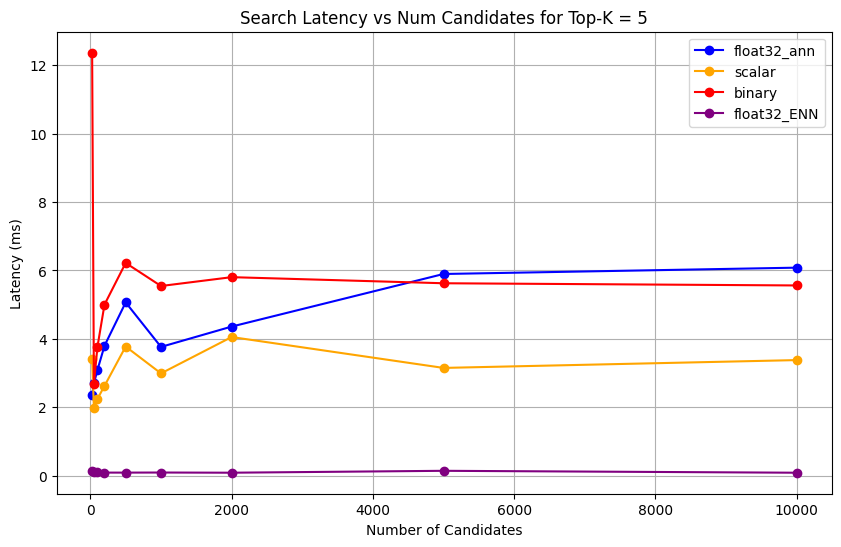

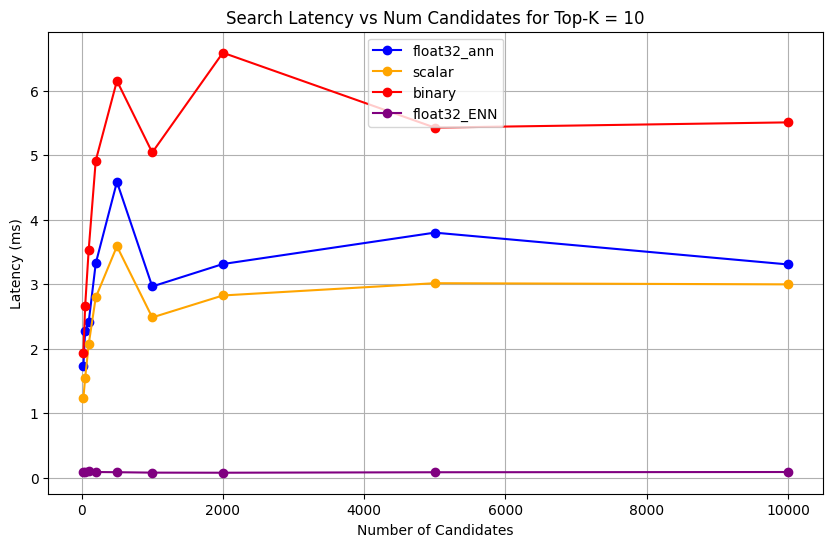

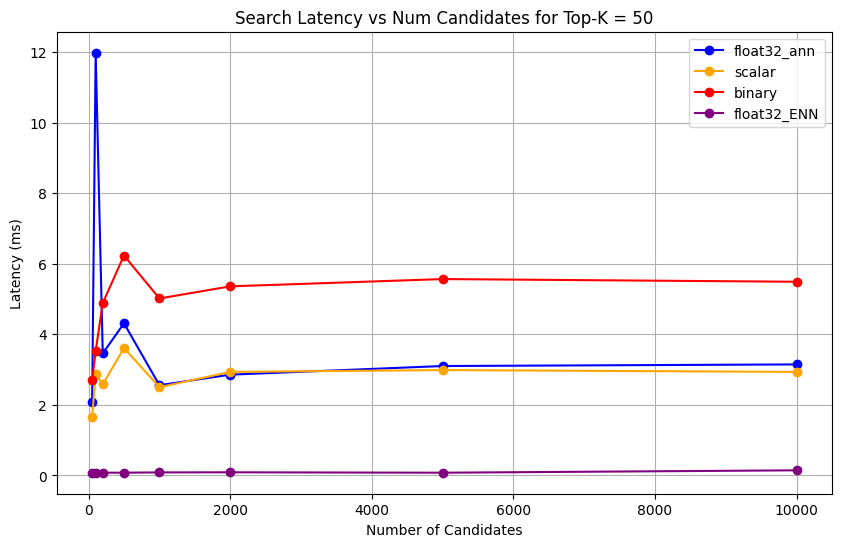

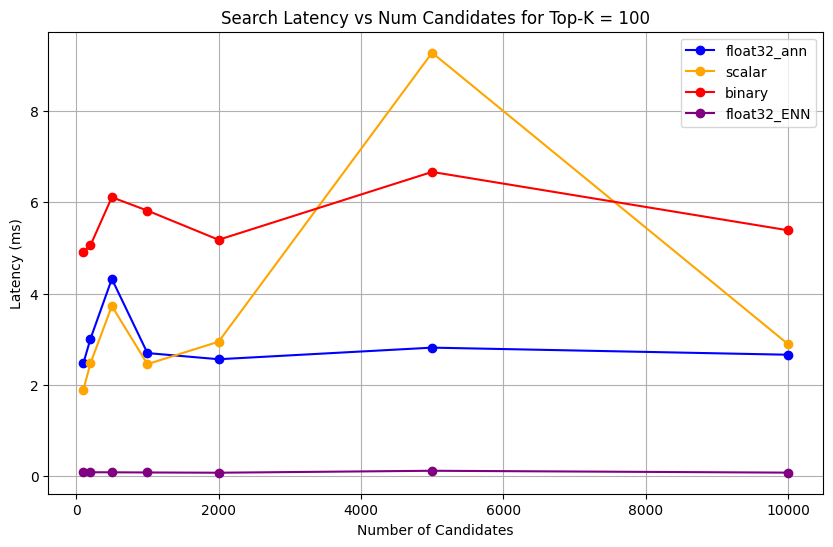

In [21]:
import matplotlib.pyplot as plt

# Map your precision field to the labels and colors you want in the legend
precision_label_map = {
    "_scalar_": "scalar",
    "_binary_": "binary",
    "_float32_ann": "float32_ann",
    "_float32_ENN": "float32_ENN",
}

precision_color_map = {
    "_scalar_": "orange",
    "_binary_": "red",
    "_float32_ann": "blue",
    "_float32_ENN": "purple",
}

# Assume latency_results is a list of lists. Each inner list corresponds to one precision type.
# Each dictionary in an inner list has keys: 'precision', 'top_k', 'num_candidates', 'latency_ms'

# Flatten all measurements and find the unique top_k values
all_measurements = [m for precision_list in latency_results for m in precision_list]
unique_topk = sorted(set(m["top_k"] for m in all_measurements))

# For each top_k, create a separate plot
for k in unique_topk:
    plt.figure(figsize=(10, 6))

    # For each precision type, filter out measurements for the current top_k value
    for measurements in latency_results:
        # Filter measurements with top_k equal to the current k
        filtered = [m for m in measurements if m["top_k"] == k]
        if not filtered:
            continue

        # Extract x (num_candidates) and y (latency) values
        x = [m["num_candidates"] for m in filtered]
        y = [m["latency_ms"] for m in filtered]

        # Determine the precision, label, and color from the first measurement in this filtered list
        precision = filtered[0]["precision"]
        label = precision_label_map.get(precision, precision)
        color = precision_color_map.get(precision, "blue")

        # Plot the line for this precision type
        plt.plot(x, y, marker="o", color=color, label=label)

    # Label axes and add title including the top_k value
    plt.xlabel("Number of Candidates")
    plt.ylabel("Latency (ms)")
    plt.title(f"Search Latency vs Num Candidates for Top-K = {k}")

    # Add a legend and grid, then show the plot
    plt.legend()
    plt.grid(True)
    plt.show()

In [22]:
def measure_representational_capacity_retention_against_float_enn(
    ground_truth_collection,
    collection,
    quantized_index_name,  # This is used for both the quantized search and (with use_full_precision=True) for the baseline.
    top_k_values,  # List/array of top-k values to test.
    num_candidates_values,  # List/array of num_candidates values to test.
    num_queries_to_test=1,
):
    retention_results = {"per_query_retention": {}}
    overall_retention = {}  # overall_retention[top_k][num_candidates] = [list of retention values]

    # Initialize overall retention structure
    for top_k in top_k_values:
        overall_retention[top_k] = {}
        for num_candidates in num_candidates_values:
            if num_candidates < top_k:
                continue
            overall_retention[top_k][num_candidates] = []

    # Extract and store the precision name from the quantized index name.
    precision_name = quantized_index_name.split("vector_index")[1]
    precision_name = precision_name.replace("quantized", "").capitalize()
    retention_results["precision_name"] = precision_name
    retention_results["top_k_values"] = top_k_values
    retention_results["num_candidates_values"] = num_candidates_values

    # Load ground truth annotations
    ground_truth_annotations = list(
        ground_truth_collection.find().limit(num_queries_to_test)
    )
    print(f"Loaded {len(ground_truth_annotations)} ground truth annotations")

    # Process each ground truth annotation
    for annotation in ground_truth_annotations:
        # Use the ground truth wiki_id from the annotation.
        ground_truth_wiki_id = annotation["wiki_id"]

        # Process only queries that are questions.
        for query_type, queries in annotation["queries"].items():
            if query_type.lower() not in ["question", "questions"]:
                continue

            for query in queries:
                # Prepare nested dict for this query
                if query not in retention_results["per_query_retention"]:
                    retention_results["per_query_retention"][query] = {}

                # For each valid combination of top_k and num_candidates
                for top_k in top_k_values:
                    if top_k not in retention_results["per_query_retention"][query]:
                        retention_results["per_query_retention"][query][top_k] = {}
                    for num_candidates in num_candidates_values:
                        if num_candidates < top_k:
                            continue

                        # Baseline search: full precision using ENN (Float32)
                        baseline_result = custom_vector_search(
                            user_query=query,
                            collection=collection,
                            embedding_path="embedding",
                            vector_search_index_name=quantized_index_name,
                            top_k=top_k,
                            num_candidates=num_candidates,
                            use_full_precision=True,
                        )
                        baseline_ids = {
                            res["wiki_id"] for res in baseline_result["results"]
                        }

                        # Quantized search:
                        quantized_result = custom_vector_search(
                            user_query=query,
                            collection=collection,
                            embedding_path="embedding",
                            vector_search_index_name=quantized_index_name,
                            top_k=top_k,
                            num_candidates=num_candidates,
                            use_full_precision=False,
                        )
                        quantized_ids = {
                            res["wiki_id"] for res in quantized_result["results"]
                        }

                        # Compute retention for this combination
                        if baseline_ids:
                            retention = len(
                                baseline_ids.intersection(quantized_ids)
                            ) / len(baseline_ids)
                        else:
                            retention = 0

                        # Store the results per query
                        retention_results["per_query_retention"][query].setdefault(
                            top_k, {}
                        )[num_candidates] = {
                            "ground_truth_wiki_id": ground_truth_wiki_id,
                            "baseline_ids": sorted(baseline_ids),
                            "quantized_ids": sorted(quantized_ids),
                            "retention": retention,
                        }
                        overall_retention[top_k][num_candidates].append(retention)

                        print(
                            f"Query: '{query}' | top_k: {top_k}, num_candidates: {num_candidates}"
                        )
                        print(f"  Ground Truth wiki_id: {ground_truth_wiki_id}")
                        print(f"  Baseline IDs (Float32): {sorted(baseline_ids)}")
                        print(
                            f"  Quantized IDs: {precision_name}: {sorted(quantized_ids)}"
                        )
                        print(f"  Retention: {retention:.4f}\n")

    # Compute overall average retention per combination
    avg_overall_retention = {}
    for top_k, cand_dict in overall_retention.items():
        avg_overall_retention[top_k] = {}
        for num_candidates, retentions in cand_dict.items():
            if retentions:
                avg = sum(retentions) / len(retentions)
            else:
                avg = 0
            avg_overall_retention[top_k][num_candidates] = avg
            print(
                f"Overall Average Retention for top_k {top_k}, num_candidates {num_candidates}: {avg:.4f}"
            )

    retention_results["average_retention"] = avg_overall_retention
    return retention_results

In [23]:
# Access the database
DB_NAME = "testing_datasets"
db = mongo_client[DB_NAME]

# Access collections
wiki_data_collection = db["wikipedia-22-12-en"]
ground_truth_collection = db["wikipedia-22-12-en-annotation"]

overall_recall_results = []
top_k_values = [5, 10, 50, 100]
num_candidates_values = [25, 50, 100, 200, 500, 1000, 5000]
num_queries_to_test = 1

for vector_search_index in vector_search_indices:
    overall_recall_results.append(
        measure_representational_capacity_retention_against_float_enn(
            ground_truth_collection=ground_truth_collection,
            collection=wiki_data_collection,
            quantized_index_name=vector_search_index,
            top_k_values=top_k_values,
            num_candidates_values=num_candidates_values,
            num_queries_to_test=num_queries_to_test,
        )
    )

Loaded 1 ground truth annotations
Query: 'What happened in 2022?' | top_k: 5, num_candidates: 25
  Ground Truth wiki_id: 69407798
  Baseline IDs (Float32): [70149799]
  Quantized IDs: _float32_ann: [70149799]
  Retention: 1.0000

Query: 'What happened in 2022?' | top_k: 5, num_candidates: 50
  Ground Truth wiki_id: 69407798
  Baseline IDs (Float32): [70149799]
  Quantized IDs: _float32_ann: [70149799]
  Retention: 1.0000

Query: 'What happened in 2022?' | top_k: 5, num_candidates: 100
  Ground Truth wiki_id: 69407798
  Baseline IDs (Float32): [70149799]
  Quantized IDs: _float32_ann: [70149799]
  Retention: 1.0000

Query: 'What happened in 2022?' | top_k: 5, num_candidates: 200
  Ground Truth wiki_id: 69407798
  Baseline IDs (Float32): [70149799]
  Quantized IDs: _float32_ann: [70149799]
  Retention: 1.0000

Query: 'What happened in 2022?' | top_k: 5, num_candidates: 500
  Ground Truth wiki_id: 69407798
  Baseline IDs (Float32): [70149799]
  Quantized IDs: _float32_ann: [70149799]
  Re

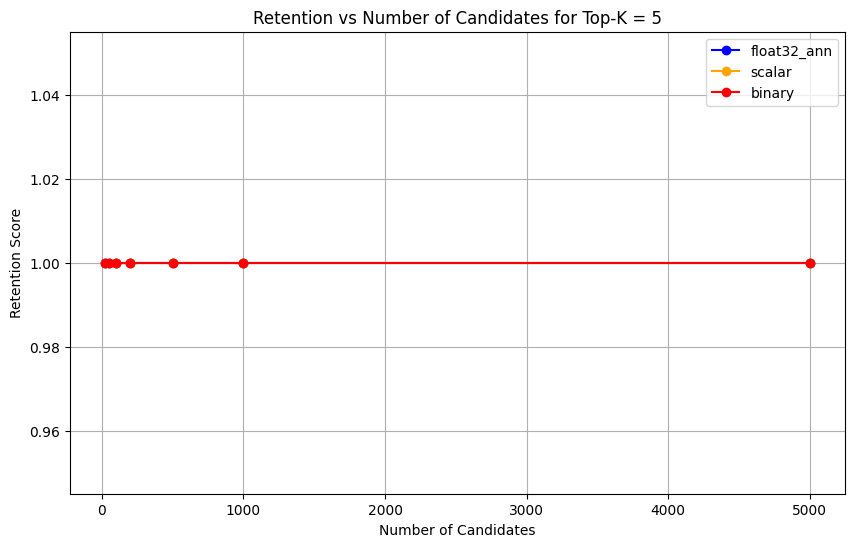

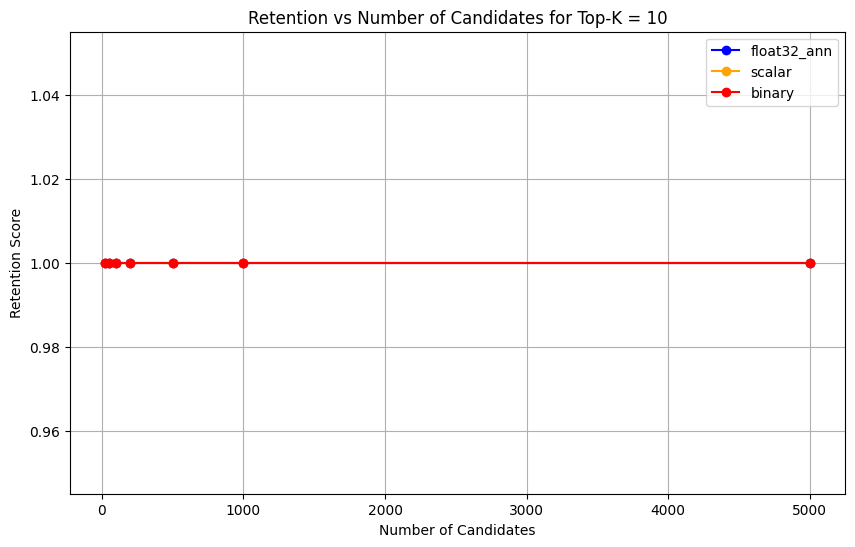

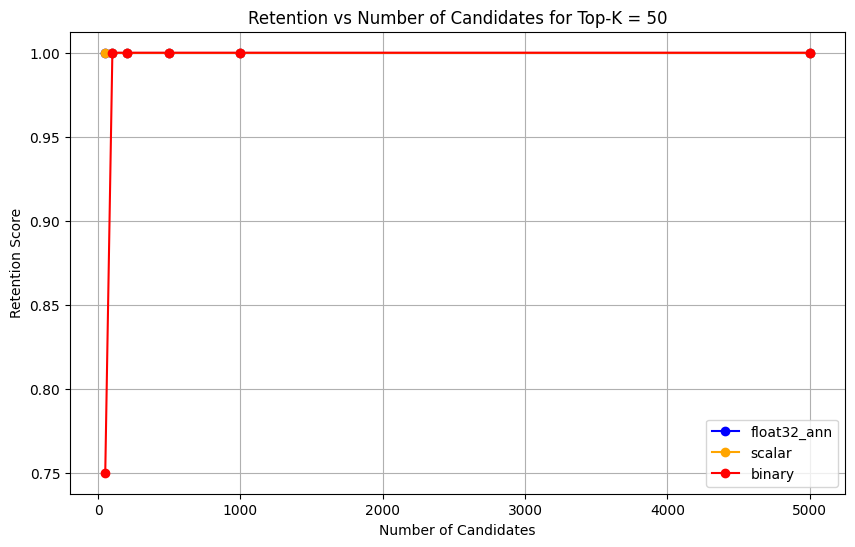

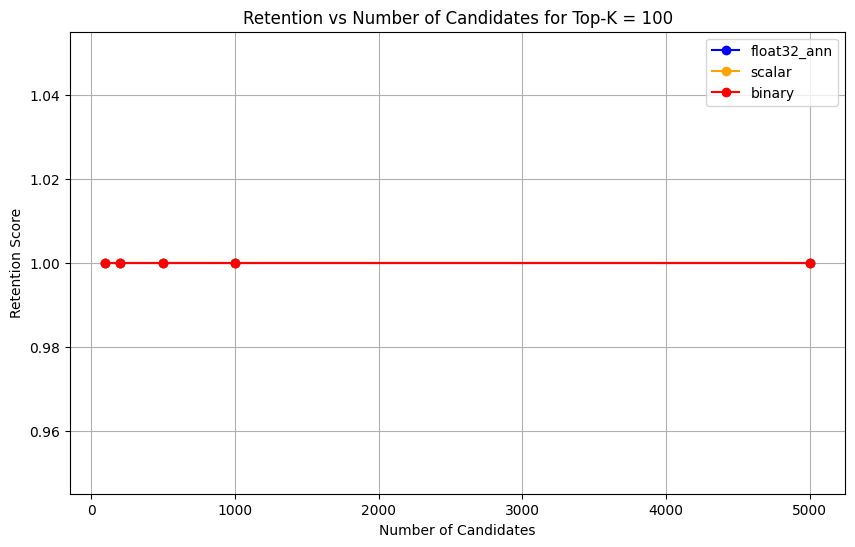


Detailed Average Retention Results:

_float32_ann Embedding:

Top-K: 5
   NumCandidates: 25, Retention: 1.0000
   NumCandidates: 50, Retention: 1.0000
   NumCandidates: 100, Retention: 1.0000
   NumCandidates: 200, Retention: 1.0000
   NumCandidates: 500, Retention: 1.0000
   NumCandidates: 1000, Retention: 1.0000
   NumCandidates: 5000, Retention: 1.0000

Top-K: 10
   NumCandidates: 25, Retention: 1.0000
   NumCandidates: 50, Retention: 1.0000
   NumCandidates: 100, Retention: 1.0000
   NumCandidates: 200, Retention: 1.0000
   NumCandidates: 500, Retention: 1.0000
   NumCandidates: 1000, Retention: 1.0000
   NumCandidates: 5000, Retention: 1.0000

Top-K: 50
   NumCandidates: 50, Retention: 1.0000
   NumCandidates: 100, Retention: 1.0000
   NumCandidates: 200, Retention: 1.0000
   NumCandidates: 500, Retention: 1.0000
   NumCandidates: 1000, Retention: 1.0000
   NumCandidates: 5000, Retention: 1.0000

Top-K: 100
   NumCandidates: 100, Retention: 1.0000
   NumCandidates: 200, Retention

In [24]:
import matplotlib.pyplot as plt

# Define colors and labels for each precision type
precision_colors = {"_scalar_": "orange", "_binary_": "red", "_float32_": "green"}

# Assume overall_retention_results is a list of dictionaries returned by your
# measure_representational_capacity_retention_against_float_enn function.
# Each dictionary should contain:
#   - 'precision_name': the precision type (e.g., '_scalar_')
#   - 'average_retention': a dict mapping each top_k to a dict mapping num_candidates
#                           to the average retention, e.g.,
#                           average_retention[top_k][num_candidates] = retention_value

if overall_recall_results:
    # Determine unique top_k values from the first result's average_retention keys
    unique_topk = sorted(list(overall_recall_results[0]["average_retention"].keys()))

    for k in unique_topk:
        plt.figure(figsize=(10, 6))
        # For each precision type, plot retention vs. number of candidates at this top_k
        for result in overall_recall_results:
            precision_name = result.get("precision_name", "unknown")
            color = precision_colors.get(precision_name, "blue")
            # Get candidate values from the average_retention dictionary for top_k k
            candidate_values = sorted(result["average_retention"][k].keys())
            retention_values = [
                result["average_retention"][k][nc] for nc in candidate_values
            ]

            plt.plot(
                candidate_values,
                retention_values,
                marker="o",
                label=precision_name.strip("_"),
                color=color,
            )

        plt.xlabel("Number of Candidates")
        plt.ylabel("Retention Score")
        plt.title(f"Retention vs Number of Candidates for Top-K = {k}")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Print detailed average retention results
    print("\nDetailed Average Retention Results:")
    for result in overall_recall_results:
        precision_name = result.get("precision_name", "unknown")
        print(f"\n{precision_name} Embedding:")
        for k in sorted(result["average_retention"].keys()):
            print(f"\nTop-K: {k}")
            for nc in sorted(result["average_retention"][k].keys()):
                ret = result["average_retention"][k][nc]
                print(f"   NumCandidates: {nc}, Retention: {ret:.4f}")